In [1]:
import __init__
from __init__ import DATA_PATH, PACKAGE_PATH
from dce import DCE
from cluster import Cluster
import utilities
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras import Model
%matplotlib inline

Using TensorFlow backend.


In [5]:
from descriptor import mordredDescriptors as mDesc

(array([673.,   0.,   0.,   0.,   0., 191.,   0.,   0.,   0., 199.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

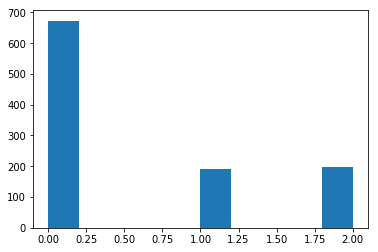

In [6]:
df = pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])

df['tri_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [20,80])
true_label_triclass = df['tri_class_partition'].values

df['bi_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(true_label_triclass)

In [8]:
feat_int = mDesc.batch_compute_all_descriptors(df['SMILES'], desc_type='int')

 42%|████▏     | 447/1063 [00:07<00:08, 70.80it/s]

/Users/hanghu/miniconda3/envs/deepchembed/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 47%|████▋     | 502/1063 [00:08<00:13, 40.74it/s]

/Users/hanghu/miniconda3/envs/deepchembed/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 60%|██████    | 640/1063 [00:12<00:23, 17.93it/s]

/Users/hanghu/miniconda3/envs/deepchembed/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 91%|█████████▏| 970/1063 [00:19<00:03, 24.99it/s]

/Users/hanghu/miniconda3/envs/deepchembed/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 94%|█████████▍| 999/1063 [00:20<00:02, 29.63it/s]

/Users/hanghu/miniconda3/envs/deepchembed/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 96%|█████████▌| 1017/1063 [00:21<00:01, 25.21it/s]

/Users/hanghu/miniconda3/envs/deepchembed/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 97%|█████████▋| 1033/1063 [00:22<00:01, 20.81it/s]

/Users/hanghu/miniconda3/envs/deepchembed/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1063/1063 [00:22<00:00, 46.99it/s]


In [9]:
from sklearn.preprocessing import normalize
selected_int_feat = feat_int.loc[:,feat_int.nunique()>1]
norm_int_train = normalize(selected_int_feat.values, axis=0, norm='max')
len(norm_int_train[0])

187

### autoencoder

In [10]:
from dimreducer import DeepAutoEncoder as DAE
dims = [187, 90, 45]
autoencoder = DAE(dims)
autoencoder.build_model()
history = autoencoder.train_model(norm_int_train, epochs=50,verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


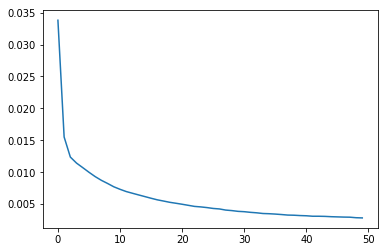

In [11]:
plt.plot(history.history['loss'])

## cluster = 2

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    norm_int_train, true_label_biclass, test_size=0.25, random_state=42)

### test on baseline model: just supervised learning

### test on autoencoder + supervised learning

### test supervised dce


In [13]:
autoencoder_dims = [187, 90, 45]
dce = DCE(autoencoder_dims, n_clusters=2, update_interval=20)
cl_weights = np.arange(0.1, 1, 0.1)
train_loss = []
test_loss = []
train_hidden_feats = []
test_hidden_feats = []
train_y_pred = []
test_y_pred = []

for cl_weight in cl_weights:
    dce.build_model(norm=True)
    print('Start to train model with cluster weight: ' + str(cl_weight))
    train_loss_i, test_loss_i = dce.train_model(data_train=X_train, labels_train=y_train,
                                                data_test=X_test, labels_test=y_test,
                                                clustering_loss='kld', decoder_loss='mse',
                                                verbose=0,clustering_loss_weight=cl_weight)
    train_loss.append(train_loss_i)
    test_loss.append(test_loss_i)
    
    q, _ = dce.model.predict(X_train)
    train_y_pred.append(q.argmax(1))
    
    q, _ = dce.model.predict(X_test)
    test_y_pred.append(q.argmax(1))
    
    encoder = Model(inputs=dce.model.input, 
                    outputs=dce.model.get_layer(name='embedding_layer').output)
    
    train_hidden_feats.append(encoder.predict(X_train))
    test_hidden_feats.append(encoder.predict(X_test))
    
    print('Training finished and the results are recorded')

Start to train model with cluster weight: 0.1
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.2
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.30000000000000004
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.4
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.5
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.6
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.7000000000000001

#### Losses 

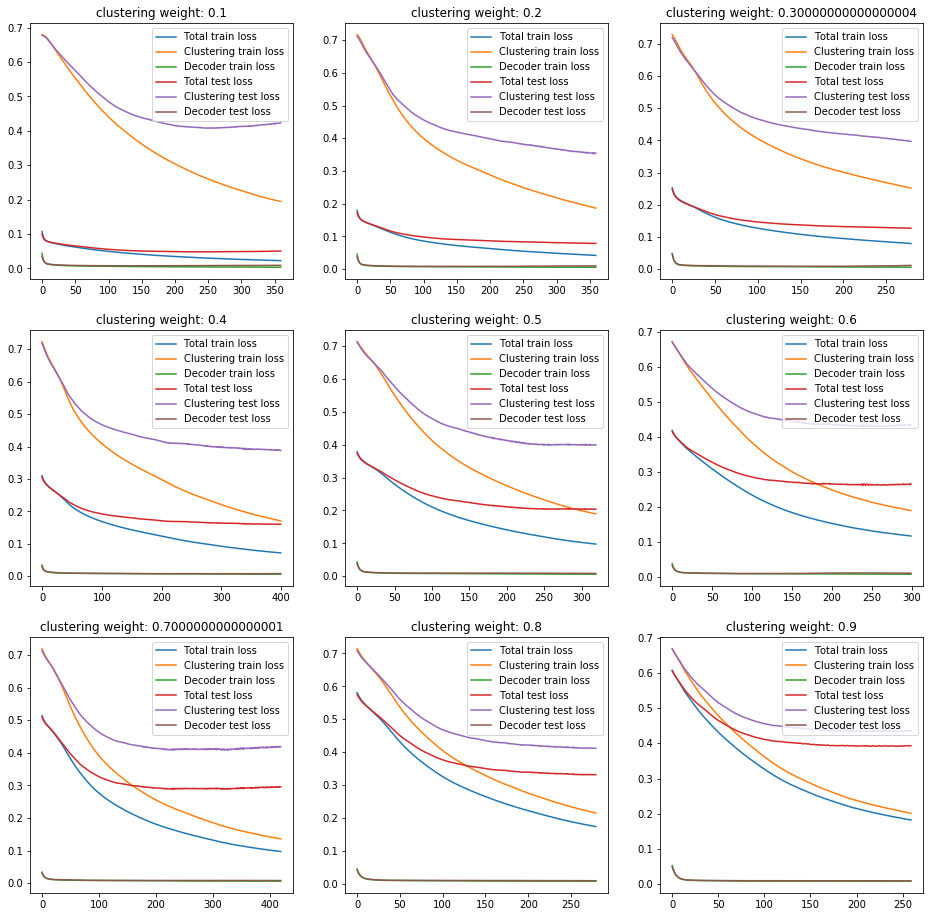

In [14]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3

    ax[row_i][column_j].plot(train_loss[i][0],label='Total train loss')
    ax[row_i][column_j].plot(train_loss[i][1],label='Clustering train loss')
    ax[row_i][column_j].plot(train_loss[i][2],label='Decoder train loss')
    ax[row_i][column_j].plot(test_loss[i][0],label='Total test loss')
    ax[row_i][column_j].plot(test_loss[i][1],label='Clustering test loss')
    ax[row_i][column_j].plot(test_loss[i][2],label='Decoder test loss')
    ax[row_i][column_j].legend()
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

#### Scores

Text(0.5, 1.0, 'Test fowlkes_mallows_score')

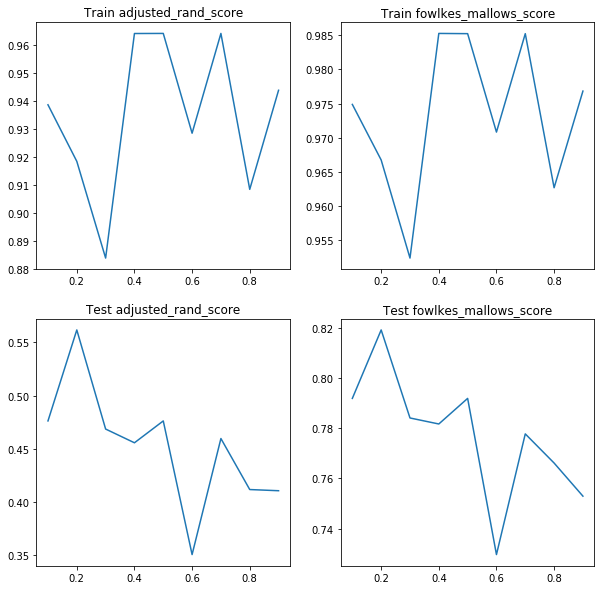

In [15]:
adjusted_rand_score = []
fowlkes_mallows_score = []
for i in range(9):
    metric_dict = Cluster.true_label_metrics(y_train,train_y_pred[i],print_metric=False)
    adjusted_rand_score.append(metric_dict['adjusted_rand_score'])
    fowlkes_mallows_score.append(metric_dict['fowlkes_mallows_score'])

fig, ax =plt.subplots(2,2,figsize=(10,10))

ax[0][0].plot(cl_weights,adjusted_rand_score)
ax[0][0].set_title('Train adjusted_rand_score')

ax[0][1].plot(cl_weights,fowlkes_mallows_score)
ax[0][1].set_title('Train fowlkes_mallows_score')

adjusted_rand_score = []
fowlkes_mallows_score = []
for i in range(9):
    metric_dict = Cluster.true_label_metrics(y_test,test_y_pred[i],print_metric=False)
    adjusted_rand_score.append(metric_dict['adjusted_rand_score'])
    fowlkes_mallows_score.append(metric_dict['fowlkes_mallows_score'])

ax[1][0].plot(cl_weights,adjusted_rand_score)
ax[1][0].set_title('Test adjusted_rand_score')

ax[1][1].plot(cl_weights,fowlkes_mallows_score)
ax[1][1].set_title('Test fowlkes_mallows_score')

#### Train Visualization using true label

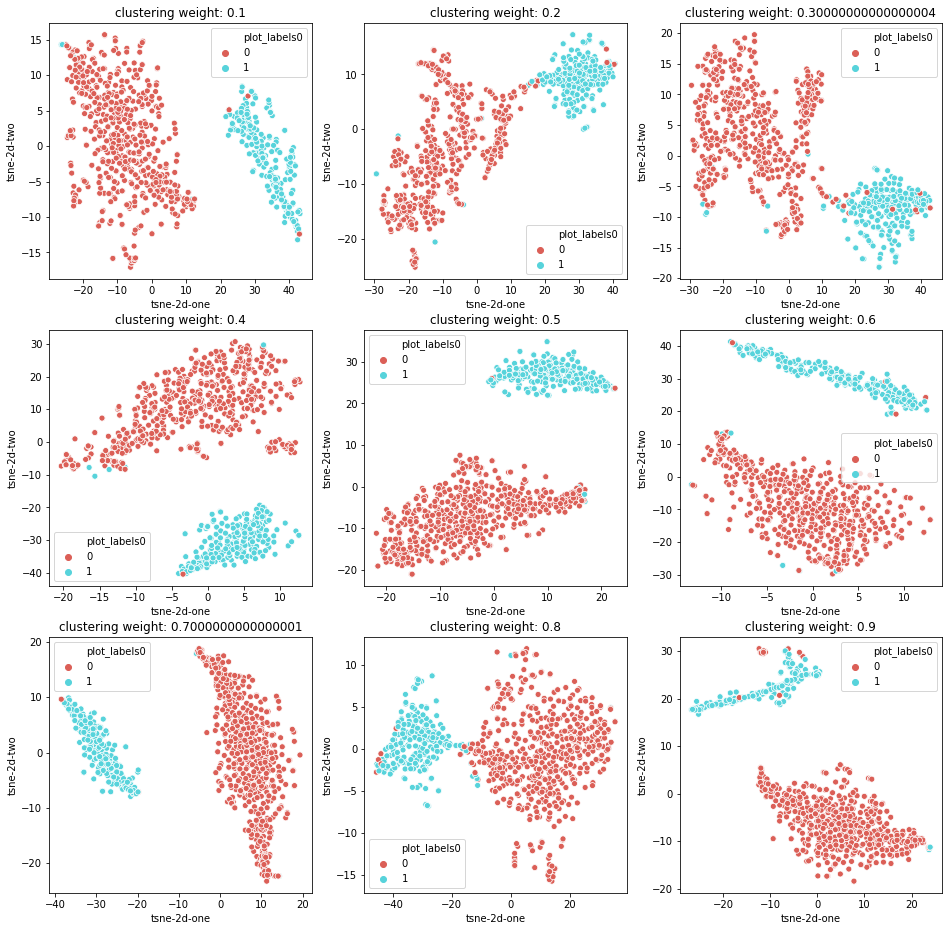

In [16]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    utilities.tsne_2d_visulization(input_feat=train_hidden_feats[i], 
                                   plot_labels=y_train,
                                   verbose=0,
                                   ax=ax[row_i][column_j])
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

#### Test Visualization using true label

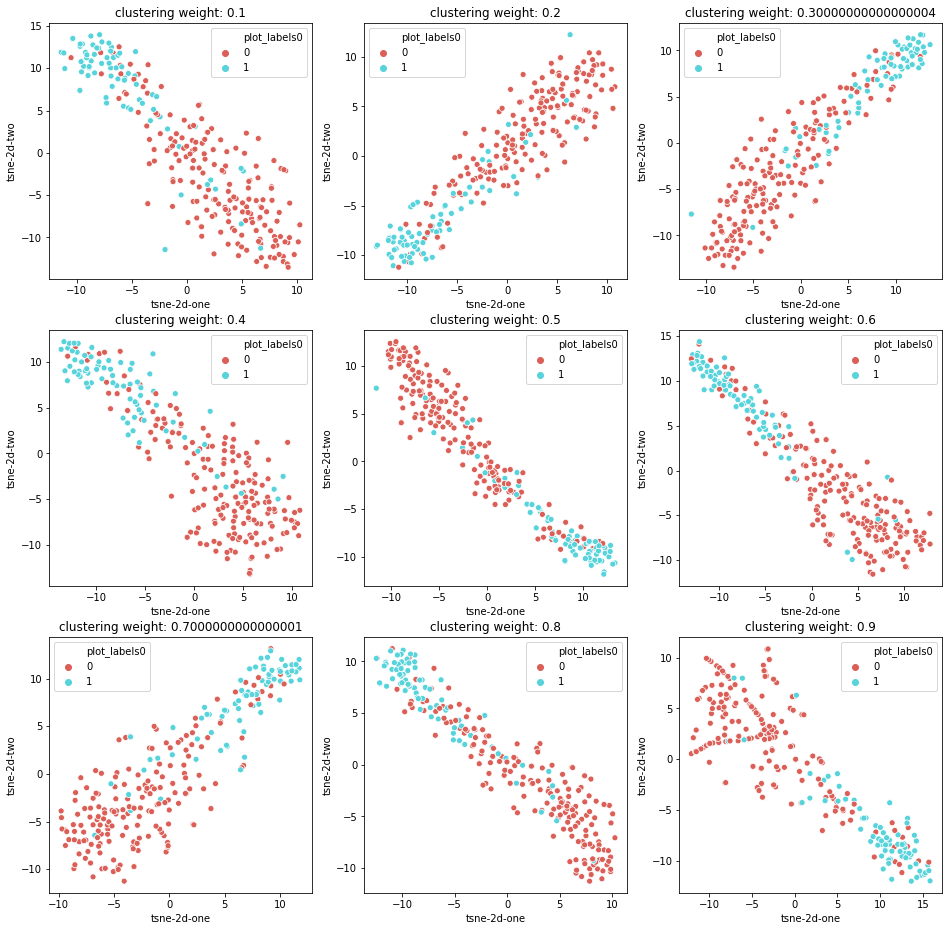

In [37]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    utilities.tsne_2d_visulization(input_feat=test_hidden_feats[i], 
                                   plot_labels=y_test,
                                   verbose=0,
                                   ax=ax[row_i][column_j])
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

## cluster = 3

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
   norm_int_train, true_label_triclass, test_size=0.25, random_state=42)

### test on baseline model: just supervised learning

### test on autoencoder + supervised learning

In [18]:
autoencoder_dims = [187, 90, 45]
dce = DCE(autoencoder_dims, n_clusters=3, update_interval=20)
cl_weights = np.arange(0.1, 1, 0.1)
train_loss = []
test_loss = []
train_hidden_feats = []
test_hidden_feats = []
train_y_pred = []
test_y_pred = []

for cl_weight in cl_weights:
    dce.build_model(norm=True)
    print('Start to train model with cluster weight: ' + str(cl_weight))
    train_loss_i, test_loss_i = dce.train_model(data_train=X_train, labels_train=y_train,
                                                data_test=X_test, labels_test=y_test,
                                                clustering_loss='kld', decoder_loss='mse',
                                                verbose=0,clustering_loss_weight=cl_weight)
    train_loss.append(train_loss_i)
    test_loss.append(test_loss_i)
    
    q, _ = dce.model.predict(X_train)
    train_y_pred.append(q.argmax(1))
    
    q, _ = dce.model.predict(X_test)
    test_y_pred.append(q.argmax(1))
    
    encoder = Model(inputs=dce.model.input, 
                    outputs=dce.model.get_layer(name='embedding_layer').output)
    
    train_hidden_feats.append(encoder.predict(X_train))
    test_hidden_feats.append(encoder.predict(X_test))
    
    print('Training finished and the results are recorded')

Start to train model with cluster weight: 0.1
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.2
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.30000000000000004
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.4
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.5
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.6
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with cluster weight: 0.7000000000000001

#### Losses

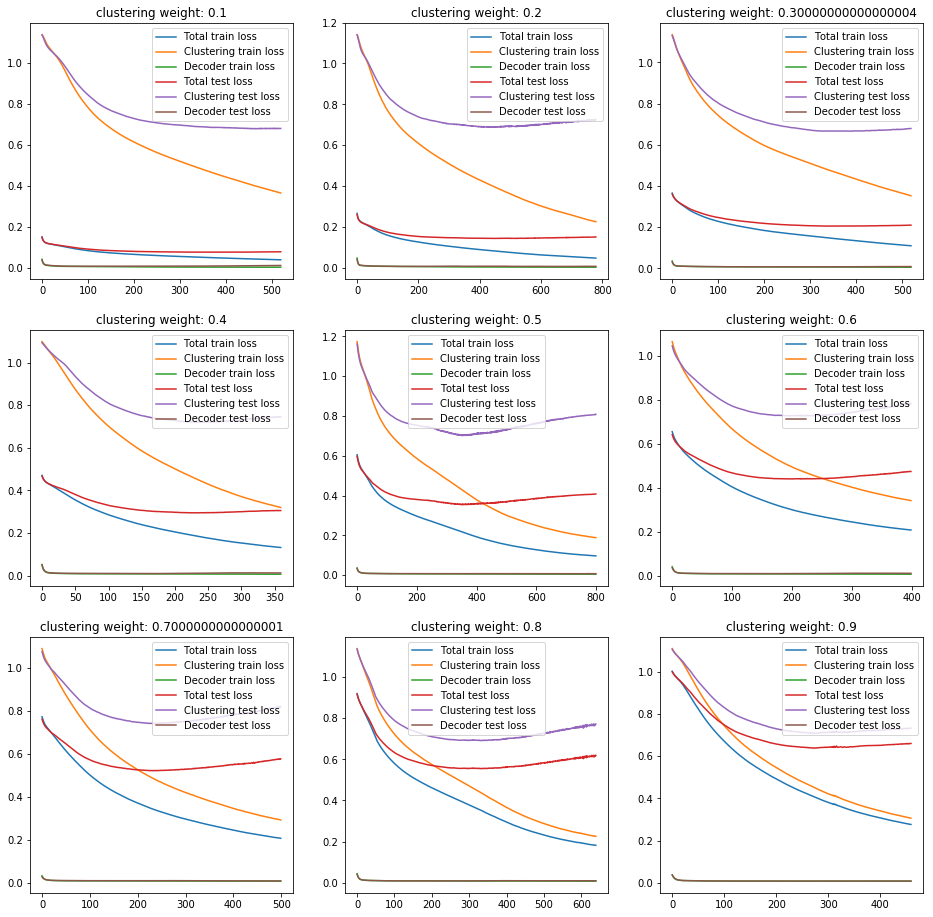

In [19]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3

    ax[row_i][column_j].plot(train_loss[i][0],label='Total train loss')
    ax[row_i][column_j].plot(train_loss[i][1],label='Clustering train loss')
    ax[row_i][column_j].plot(train_loss[i][2],label='Decoder train loss')
    ax[row_i][column_j].plot(test_loss[i][0],label='Total test loss')
    ax[row_i][column_j].plot(test_loss[i][1],label='Clustering test loss')
    ax[row_i][column_j].plot(test_loss[i][2],label='Decoder test loss')
    ax[row_i][column_j].legend()
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

#### Scores

Text(0.5, 1.0, 'Test fowlkes_mallows_score')

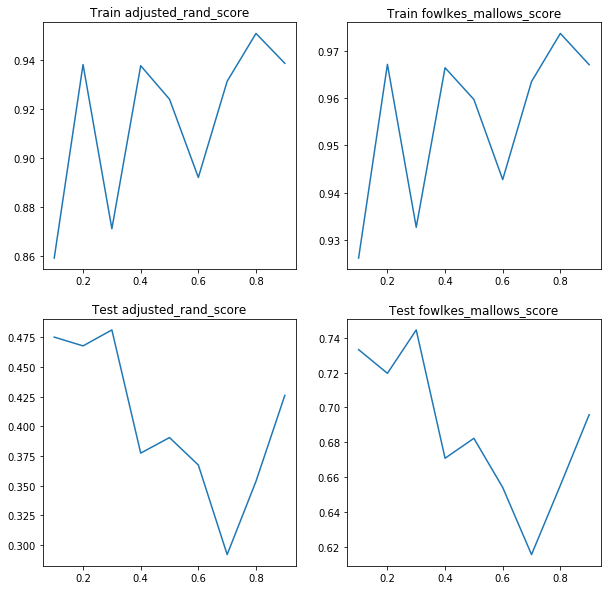

In [20]:
adjusted_rand_score = []
fowlkes_mallows_score = []
for i in range(9):
    metric_dict = Cluster.true_label_metrics(y_train,train_y_pred[i],print_metric=False)
    adjusted_rand_score.append(metric_dict['adjusted_rand_score'])
    fowlkes_mallows_score.append(metric_dict['fowlkes_mallows_score'])

fig, ax =plt.subplots(2,2,figsize=(10,10))

ax[0][0].plot(cl_weights,adjusted_rand_score)
ax[0][0].set_title('Train adjusted_rand_score')

ax[0][1].plot(cl_weights,fowlkes_mallows_score)
ax[0][1].set_title('Train fowlkes_mallows_score')

adjusted_rand_score = []
fowlkes_mallows_score = []
for i in range(9):
    metric_dict = Cluster.true_label_metrics(y_test,test_y_pred[i],print_metric=False)
    adjusted_rand_score.append(metric_dict['adjusted_rand_score'])
    fowlkes_mallows_score.append(metric_dict['fowlkes_mallows_score'])

ax[1][0].plot(cl_weights,adjusted_rand_score)
ax[1][0].set_title('Test adjusted_rand_score')

ax[1][1].plot(cl_weights,fowlkes_mallows_score)
ax[1][1].set_title('Test fowlkes_mallows_score')

#### Train Visualization using true label

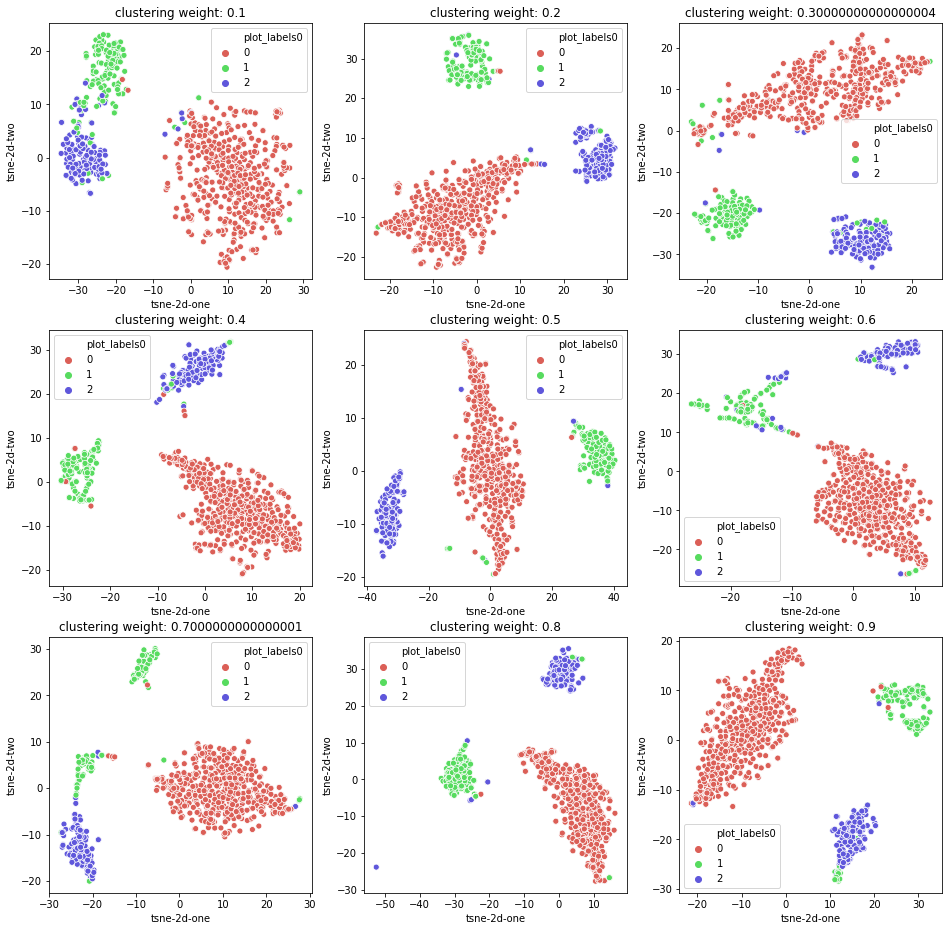

In [21]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    utilities.tsne_2d_visulization(input_feat=train_hidden_feats[i], 
                                   plot_labels=y_train,
                                   verbose=0,
                                   ax=ax[row_i][column_j])
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))

#### Test Visualization using true label

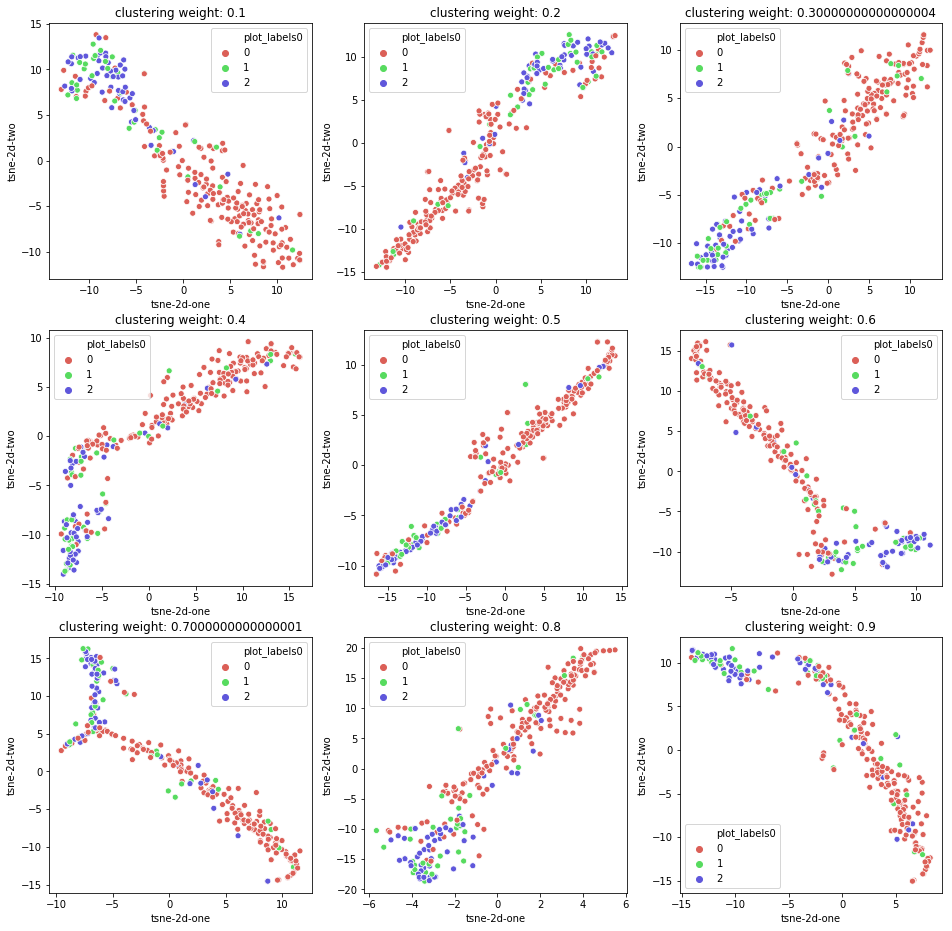

In [22]:
fig, ax =plt.subplots(3,3,figsize=(16,16))

for i in range(9):
    row_i = int(i/3)
    column_j = i % 3
    utilities.tsne_2d_visulization(input_feat=test_hidden_feats[i], 
                                   plot_labels=y_test,
                                   verbose=0,
                                   ax=ax[row_i][column_j])
    ax[row_i][column_j].set_title('clustering weight: ' + str(cl_weights[i]))